#### Introduction
In this kernel we will build a Tensorflow_2.0 Keras model to classify three types of rice leaf diseases. These diseases include leaf smut, brown spot and bacterial leaf blight. The dataset consists of only 119 images. Normally, when using deep learning, one would not expect to get very good results with so few training images. However, by using image augmentation and transfer learning, our validation accuracy score will be greater.

This is the link to the live app. The code is available on Github.

- {link}
- {link}

 

#### Data Summary
- 119 jpg images of various sizes
- 3 classes --> leaf smut, brown spot and bacterial leaf blight
- 40 images per class

#### Approach
- Resize all images to 224x224x3
- Use 25 images from each class for training (105 training images)
- Use 5 images from each class for testing (15 testing images)
- Fine tune a Mobilenet model that was pre-trained on imagenet.
- Use Adam optimizer, categorical crossentropy loss and a constant learning rate of 0.0001
- We will simply normalize all images by dividing by 255.
- Perform image augmentation using the Albumentations library. Image augmentation will help to reduce overfitting, improve model performance and help the model generalize better.

In [1]:
# Check the tensorflow version

import tensorflow as tf
tf.__version__

'2.5.0'

In [3]:
#Import all essential libraries

import pandas as pd
import numpy as np
import os

import cv2

import albumentations as albu
from albumentations import Compose, ShiftScaleRotate, Resize
from albumentations.pytorch import ToTensor


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report

import shutil

import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3


In [5]:
os.listdir('D:\Datamites\PROJ3- PRCP-1001-RiceLeaf\Labelled')

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

## Prepare the Data

### Create a dataframe containing all the images

In [6]:
#We prepare a list containing all the images 
leaf_smut_list = \
os.listdir('D:\Datamites\PROJ3- PRCP-1001-RiceLeaf\Labelled/Leaf smut')
brown_spot_list = \
os.listdir('D:\Datamites\PROJ3- PRCP-1001-RiceLeaf\Labelled/Brown spot')
bacterial_leaf_blight_list = \
os.listdir('D:\Datamites\PROJ3- PRCP-1001-RiceLeaf\Labelled/Bacterial leaf blight')

print(len(leaf_smut_list))
print(len(brown_spot_list))
print(len(bacterial_leaf_blight_list))

39
40
40


In [7]:
# Create the train and validation sets

df_leaf_smut = pd.DataFrame(leaf_smut_list, columns=['image'])
df_leaf_smut['target'] = 'leaf_smut'

df_brown_spot = pd.DataFrame(brown_spot_list, columns=['image'])
df_brown_spot['target'] = 'brown_spot'

df_bacterial_leaf_blight = pd.DataFrame(bacterial_leaf_blight_list, columns=['image'])
df_bacterial_leaf_blight['target'] = 'bacterial_leaf_blight'


# Create a validation set for each class

# Sample 5 validation images from each class
df_leaf_smut_val = df_leaf_smut.sample(n=5, random_state=101)
df_brown_spot_val = df_brown_spot.sample(n=5, random_state=101)
df_bacterial_leaf_blight_val = df_bacterial_leaf_blight.sample(n=5, random_state=101)


print(len(df_leaf_smut_val))
print(len(df_brown_spot_val))
print(len(df_bacterial_leaf_blight_val))

5
5
5


In [8]:
# Create the train set for each class

# leaf_smut
# get a list of val images
val_list = list(df_leaf_smut_val['image'])
# filter out the val images
df_leaf_smut_train = df_leaf_smut[~df_leaf_smut['image'].isin(val_list)] # ~ means notin

# brown_spot
# get a list of val images
val_list = list(df_brown_spot_val['image'])
# filter out the val images
df_brown_spot_train = df_brown_spot[~df_brown_spot['image'].isin(val_list)] # ~ means notin

# bacterial_leaf_blight
# get a list of val images
val_list = list(df_bacterial_leaf_blight_val['image'])
# filter out the val images
df_bacterial_leaf_blight_train = \
df_bacterial_leaf_blight[~df_bacterial_leaf_blight['image'].isin(val_list)] # ~ means notin



print(len(df_leaf_smut_train))
print(len(df_brown_spot_train))
print(len(df_bacterial_leaf_blight_train))

34
35
35


In [17]:
# Create df_data, df_train and df_val

df_data = pd.concat([df_leaf_smut, df_brown_spot, df_bacterial_leaf_blight], axis=0).reset_index(drop=True)

df_train = \
pd.concat([df_leaf_smut_train, df_brown_spot_train, df_bacterial_leaf_blight_train], axis=0).reset_index(drop=True)

df_val = \
pd.concat([df_leaf_smut_val, df_brown_spot_val, df_bacterial_leaf_blight_val], axis=0).reset_index(drop=True)

#Shuffles the data
df_data = shuffle(df_data)
df_train = shuffle(df_train)
df_val = shuffle(df_val)

print(df_data.shape)
print(df_train.shape)
print(df_val.shape)

(119, 2)
(104, 2)
(15, 2)


In [18]:
df_data['target'].value_counts()

bacterial_leaf_blight    40
brown_spot               40
leaf_smut                39
Name: target, dtype: int64

In [19]:
df_train['target'].value_counts()

bacterial_leaf_blight    35
brown_spot               35
leaf_smut                34
Name: target, dtype: int64

In [20]:
df_val['target'].value_counts()

leaf_smut                5
bacterial_leaf_blight    5
brown_spot               5
Name: target, dtype: int64

### Transform the target 

Here we will one hot encode the target classes.

In [21]:
# Create the target as index values

# combine val, train and test
val_len = len(df_val)
train_len = len(df_train)
df_combined =  pd.concat(objs=[df_val, df_train], axis=0).reset_index(drop=True)

# create the dummy variables
df_combined = pd.get_dummies(df_combined, columns=['target'])

# separate the train and val sets
df_val = df_combined[:val_len]
df_train = df_combined[val_len:]


print(df_train.shape)
print(df_val.shape)

(104, 4)
(15, 4)


In [22]:
df_combined.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
0,DSC_0333.JPG,0,1,0
1,DSC_0504.jpg,0,0,1
2,DSC_0396.JPG,1,0,0
3,DSC_0384.JPG,1,0,0
4,DSC_0302.JPG,0,1,0


In [23]:
df_train.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
15,DSC_0380.JPG,1,0,0
16,DSC_0505.jpg,0,0,1
17,DSC_0395.JPG,1,0,0
18,DSC_0106.jpg,0,1,0
19,DSC_0514.jpg,0,0,1


In [24]:
df_val.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
0,DSC_0333.JPG,0,1,0
1,DSC_0504.jpg,0,0,1
2,DSC_0396.JPG,1,0,0
3,DSC_0384.JPG,1,0,0
4,DSC_0302.JPG,0,1,0


## Save the dataframes as compressed csv files
These csv files will allow us to use Pandas chunking to feed images into the generators.

In [25]:
df_combined.to_csv('df_combined.csv.gz', compression='gzip', index=False)

df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)


In [27]:
ls

 Volume in drive D is New Volume
 Volume Serial Number is EA44-CFBB

 Directory of D:\Datamites\PROJ3- PRCP-1001-RiceLeaf

19-07-2021  15:21    <DIR>          .
19-07-2021  15:21    <DIR>          ..
19-07-2021  15:19    <DIR>          .ipynb_checkpoints
18-07-2021  15:01    <DIR>          aug
16-07-2021  15:12    <DIR>          Combined
19-07-2021  15:21               493 df_combined.csv.gz
18-07-2021  18:07               186 df_test.csv.gz
19-07-2021  15:21               447 df_train.csv.gz
19-07-2021  15:21               182 df_val.csv.gz
17-07-2021  16:13    <DIR>          image_dir
16-07-2021  15:13    <DIR>          Labelled
18-07-2021  15:05    <DIR>          Labelledaug
19-07-2021  14:17        51,385,024 model.h5
17-07-2021  18:44           321,861 rice leaf 3.ipynb
18-07-2021  14:44           548,393 rice leaf 3-augmentation.ipynb
19-07-2021  15:12           602,540 rice leaf 3-augmentation-MobileNet.ipynb
18-07-2021  15:47           561,861 rice leaf 3-Image data generator.i

### Move all images to the same folder

In [29]:
# Create a new directory
image_dir = 'image_dir'
os.mkdir(image_dir)

ls

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'image_dir'

In [31]:
leaf_smut_list = \
os.listdir('D:\Datamites\PROJ3- PRCP-1001-RiceLeaf\Labelled/Leaf smut')
brown_spot_list = \
os.listdir('D:\Datamites\PROJ3- PRCP-1001-RiceLeaf\Labelled/Brown spot')
bacterial_leaf_blight_list = \
os.listdir('D:\Datamites\PROJ3- PRCP-1001-RiceLeaf\Labelled/Bacterial leaf blight')


# Transfer the leaf_smut images
for fname in leaf_smut_list:
    
    path = 'D:\Datamites\PROJ3- PRCP-1001-RiceLeaf\Labelled/Leaf smut/'
    
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    
    
    
    
# Transfer the brown_spot images
for fname in brown_spot_list:
    
    path = 'D:\Datamites\PROJ3- PRCP-1001-RiceLeaf\Labelled/Brown spot/'
    
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    
    
    
    
# Transfer the bacterial_leaf_blight images
for fname in bacterial_leaf_blight_list:
    
    path = 'D:\Datamites\PROJ3- PRCP-1001-RiceLeaf\Labelled/Bacterial leaf blight/'
    
    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
       

In [32]:
# Check how many images are now in image_dir

len(os.listdir('image_dir'))

119

## Display some images by class

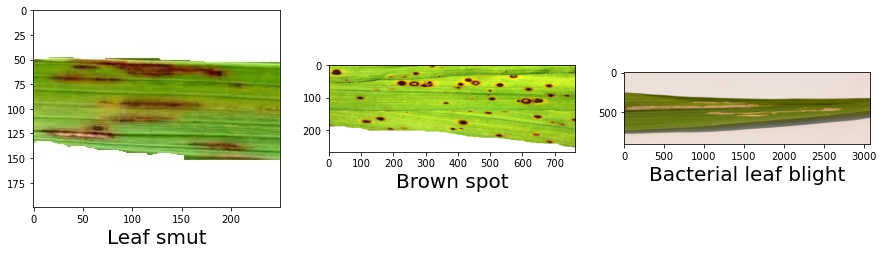

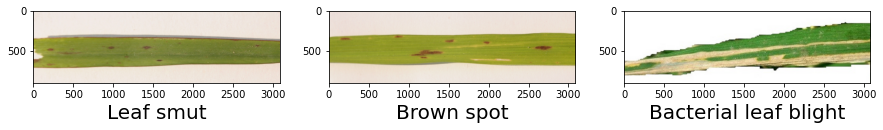

In [34]:
# set up the canvas for the subplots
plt.figure(figsize=(15,15))

# Image 1
plt.subplot(1,3,1)   # 1 row and 3 columns
item = 'DSC_0512.jpg'
path = 'D:\Datamites\PROJ3- PRCP-1001-RiceLeaf\Labelled/Leaf smut/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Leaf smut', fontsize=20)

# Image 2
plt.subplot(1,3,2)   # 1 row and 3 columns
item = 'DSC_0108.jpg'
path = 'D:\Datamites\PROJ3- PRCP-1001-RiceLeaf\Labelled/Brown spot/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Brown spot', fontsize=20)

# Image 2
plt.subplot(1,3,3)   # 1 row and 3 columns
item = 'DSC_0402.JPG'
path = 'D:\Datamites\PROJ3- PRCP-1001-RiceLeaf\Labelled/Bacterial leaf blight/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Bacterial leaf blight', fontsize=20)






# set up the canvas for the subplots
plt.figure(figsize=(15,15))

# Image 1
plt.subplot(1,3,1)   # 1 row and 3 columns
item = 'DSC_0316.JPG'
path = 'D:\Datamites\PROJ3- PRCP-1001-RiceLeaf\Labelled/Leaf smut/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Leaf smut', fontsize=20)

# Image 2
plt.subplot(1,3,2)   # 1 row and 3 columns
item = 'DSC_0303.JPG'
path = 'D:\Datamites\PROJ3- PRCP-1001-RiceLeaf\Labelled/Brown spot/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Brown spot', fontsize=20)

# Image 2
plt.subplot(1,3,3)   # 1 row and 3 columns
item = 'DSC_0702.jpg'
path = 'D:\Datamites\PROJ3- PRCP-1001-RiceLeaf\Labelled/Bacterial leaf blight/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Bacterial leaf blight', fontsize=20)

plt.show()

## Set up and test the Augmentations
Perform image augmentation using the Albumentations library. Image augmentation will help to reduce overfitting, improve model performance and help the model generalize better.

In [35]:
#I've defined an image augmentation setup below. If you display some of the augmented images they may look strange. 
#It's easy to think that these images will confuse the model during training - this is what I thought at first.
#However, even though the augmented images may look a bit crazy, this approach actually works.


# Albumentations

import albumentations as albu


def augment_image(augmentation, image):

    # get the transform as a dict
    aug_image_dict =  augmentation(image=image)
    # retrieve the augmented matrix of the image
    image_matrix = aug_image_dict['image']
    
    
    return image_matrix



In [36]:
# Define the transforms


aug_types = albu.Compose([
            albu.HorizontalFlip(),
             albu.OneOf([
                albu.HorizontalFlip(),
                albu.VerticalFlip(),
                ], p=0.8),
            albu.OneOf([
                albu.RandomContrast(),
                albu.RandomGamma(),
                albu.RandomBrightness(),
                ], p=0.3),
            albu.OneOf([
                albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                albu.GridDistortion(),
                albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                ], p=0.3),
            albu.ShiftScaleRotate()
            ])



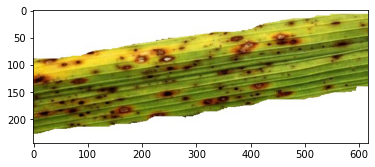

In [37]:
# Get an image to test transformations

# get a list of train png images
path = 'image_dir/'
image_list = os.listdir('image_dir')

fname = image_list[1]
image_path = path + fname

image = plt.imread(image_path)
plt.imshow(image)

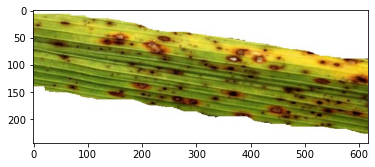

In [38]:
# Test the transformation setup.
# The image will be different each time this cell is run.

aug_image = augment_image(aug_types, image)

plt.imshow(aug_image)

## Build the Data Generators

### [ 1 ] Train Generator

In [39]:
df_train.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
15,DSC_0380.JPG,1,0,0
16,DSC_0505.jpg,0,0,1
17,DSC_0395.JPG,1,0,0
18,DSC_0106.jpg,0,1,0
19,DSC_0514.jpg,0,0,1


In [40]:
def train_generator(batch_size=8):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image'])
            
            # Create empty X matrix - 3 channels
            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            

        
            
            # Create X_train
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                
            
            
            # Create y_train
            # ===============
                cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
                y_train = df[cols]
                y_train = np.asarray(y_train) 

                # change the shape to (batch_size, 1)
                #y_train = y_train.reshape((-1, 1)) # -1 tells numpy to automatically detect the batch size
       
              
            # Augment the image and mask
            # ===========================

                aug_image = augment_image(aug_types, image)
              
                # insert the image into X_train
                X_train[i] = aug_image
                
                          
                
            # Normalize the images
            X_train = X_train/255

            yield X_train, y_train

In [41]:
# Test the generator

# initialize
train_gen = train_generator(batch_size=8)

# run the generator
X_train, y_train = next(train_gen)

print(X_train.shape)
print(y_train.shape)

(8, 224, 224, 3)
(8, 3)


In [42]:
y_train

array([[1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]], dtype=int64)

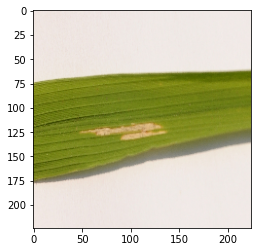

In [43]:
# Print the first image in X_train
# Remember that train images have been augmented.

image = X_train[0,:,:,:]
plt.imshow(image)

### [ 2 ] Val Generator

In [44]:
def val_generator(batch_size=5):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image'])
            
            # Create empty X matrix - 3 channels
            X_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            

        
            
            # Create X_val
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                # insert the image into X_train
                X_val[i] = image
                
                
            
            
            # Create y_val
            # ===============

                cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
                y_val = df[cols]
                y_val = np.asarray(y_val) 

                # change the shape to (batch_size, 1)
                #y_val = y_val.reshape((-1, 1)) # -1 tells numpy to automatically detect the batch size
       
            
                
                          
                
            # Normalize the images
            X_val = X_val/255

            yield X_val, y_val

In [45]:
# Test the generator

# initialize
val_gen = val_generator(batch_size=5)

# run the generator
X_val, y_val = next(val_gen)

print(X_val.shape)
print(y_val.shape)

(5, 224, 224, 3)
(5, 3)


In [46]:
y_val

array([[0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0]], dtype=int64)

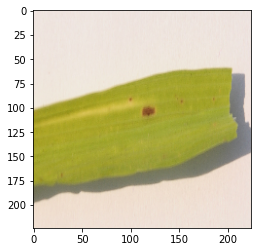

In [47]:
# print the image from X_val
image = X_val[0,:,:,:]
plt.imshow(image)

### [ 3 ] Test Generator

In [48]:
def test_generator(batch_size=1):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image'])
            
            # Create empty X matrix - 3 channels
            X_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            

        
            
            # Create X_test
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                # insert the image into X_train
                X_test[i] = image
                
                 
                
            # Normalize the images
            X_test = X_test/255

            yield X_test

In [49]:
# Test the generator

# initialize
test_gen = test_generator(batch_size=1)

# run the generator
X_test = next(test_gen)

print(X_test.shape)

(1, 224, 224, 3)


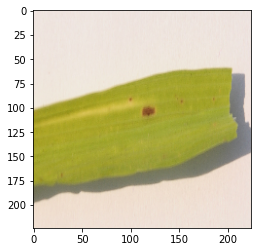

In [50]:
# print the image from X_test

image = X_test[0,:,:,:]
plt.imshow(image)

## Model Architecture

In this kernel I've used Mobilenet because my aim was to deploy the trained model online in a web app. Mobilenet was designed for use on the web. It's small which means that it downoads quickly and it runs fast.

In [51]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.metrics import categorical_accuracy

from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, 
                                        ModelCheckpoint, CSVLogger, LearningRateScheduler)


In [52]:
from tensorflow.keras.applications.mobilenet import MobileNet

model = MobileNet(weights='imagenet')

# Exclude the last 2 layers of the above model.
x = model.layers[-2].output

# Create a new dense layer for predictions
# 3 corresponds to the number of classes
predictions = Dense(3, activation='softmax')(x)

# inputs=model.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=model.input, outputs=predictions)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

## Train the Model

In [56]:
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 5

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = TRAIN_BATCH_SIZE
val_batch_size = VAL_BATCH_SIZE

# determine numtrain steps
train_steps = np.ceil(num_train_samples / train_batch_size)
# determine num val steps
val_steps = np.ceil(num_val_samples / val_batch_size)

In [55]:
# Initialize the generators
train_gen = train_generator(batch_size=TRAIN_BATCH_SIZE)
val_gen = val_generator(batch_size=VAL_BATCH_SIZE)

model.compile(
    Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)



filepath = "model.h5"

#earlystopper = EarlyStopping(patience=10, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   #verbose=1, mode='min')







history = model.fit(train_gen, steps_per_epoch=train_steps, epochs=30, 
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=checkpoint)

Epoch 1/30
13/13 [==============================] - 185s 14s/step - loss: 2.0236 - accuracy: 0.4808 - val_loss: 1.5526 - val_accuracy: 0.5333

Epoch 00001: val_accuracy improved from -inf to 0.53333, saving model to model.h5
Epoch 2/30
13/13 [==============================] - 180s 14s/step - loss: 0.9211 - accuracy: 0.7692 - val_loss: 1.7133 - val_accuracy: 0.6000

Epoch 00002: val_accuracy improved from 0.53333 to 0.60000, saving model to model.h5
Epoch 3/30
13/13 [==============================] - 133s 10s/step - loss: 0.7316 - accuracy: 0.7885 - val_loss: 2.2165 - val_accuracy: 0.7333

Epoch 00003: val_accuracy improved from 0.60000 to 0.73333, saving model to model.h5
Epoch 4/30
13/13 [==============================] - 123s 10s/step - loss: 0.4505 - accuracy: 0.8654 - val_loss: 1.1545 - val_accuracy: 0.8000

Epoch 00004: val_accuracy improved from 0.73333 to 0.80000, saving model to model.h5
Epoch 5/30
13/13 [==============================] - 130s 10s/step - loss: 0.5391 - accuracy

## Evaluate the model on the val set

In [57]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

In [59]:
model.load_weights('model.h5')

val_gen = val_generator(batch_size=1)

val_loss, val_acc = \
model.evaluate(val_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

15/15 [==============================] - 5s 339ms/step - loss: 0.5762 - accuracy: 0.8667
val_loss: 0.5762044191360474
val_acc: 0.8666666746139526


## Plot the training curves

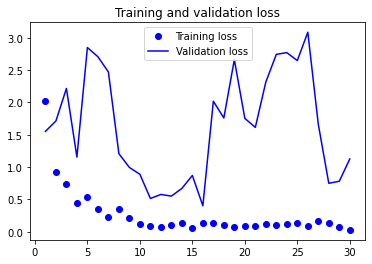

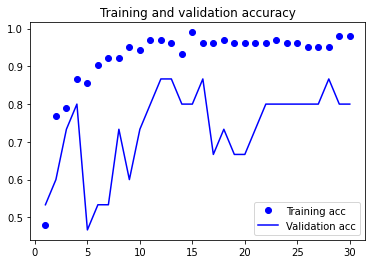

<Figure size 432x288 with 0 Axes>

In [60]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.show()

## Make a prediction on the val set

In [62]:
test_gen = test_generator(batch_size=1)

preds = model.predict(test_gen, steps=len(df_val), verbose=1)


15/15 [==============================] - 5s 316ms/step


In [63]:
# get y_pred as index values

y_pred = np.argmax(preds, axis=1)

y_pred

array([1, 2, 0, 0, 1, 1, 0, 1, 1, 2, 0, 0, 1, 2, 1], dtype=int64)

In [64]:
# get y_true as index values

cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
y_true = df_val[cols]
y_true = np.asarray(y_true) 

y_true = np.argmax(y_true, axis=1)

y_true

array([1, 2, 0, 0, 1, 1, 0, 1, 1, 2, 0, 0, 2, 2, 2], dtype=int64)

In [65]:
# Compare y_true and y_pred

print(y_pred)
print(y_true)

[1 2 0 0 1 1 0 1 1 2 0 0 1 2 1]
[1 2 0 0 1 1 0 1 1 2 0 0 2 2 2]


In [74]:
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y_true, y_pred)
cm

array([[5, 0, 0],
       [0, 5, 0],
       [0, 2, 3]], dtype=int64)

In [75]:
# bacterial_leaf_blight = 0
# brown_spot = 1
# leaf_smut = 2
pd.crosstab(y_true, y_pred)

col_0,0,1,2
row_0,,,
0,5,0,0
1,0,5,0
2,0,2,3


## Classification Report

In [76]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=['bacterial_leaf_blight', 'brown_spot', 'leaf_smut'])

print(report)

                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      1.00      1.00         5
           brown_spot       0.71      1.00      0.83         5
            leaf_smut       1.00      0.60      0.75         5

             accuracy                           0.87        15
            macro avg       0.90      0.87      0.86        15
         weighted avg       0.90      0.87      0.86        15



**Recall** = Given a class, will the classifier be able to detect it?<br>
**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.